In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import duckdb, os

In [24]:
DATA_PATH = Path("../data/telco_dataset_cleaned.csv")
df = pd.read_csv(DATA_PATH)

print("Data Shape:", df.shape)
df

Data Shape: (7032, 21)


,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No
7028,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No
7029,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7030,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,Yes


In [3]:
churn_rate = df["churn"].value_counts(normalize=True)*100
churn_rate

churn
No     73.421502
Yes    26.578498
Name: proportion, dtype: float64

C:\Users\user\AppData\Local\Temp\ipykernel_10316\3806092962.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax=sns.countplot(data=df, x="churn",palette="Set2")


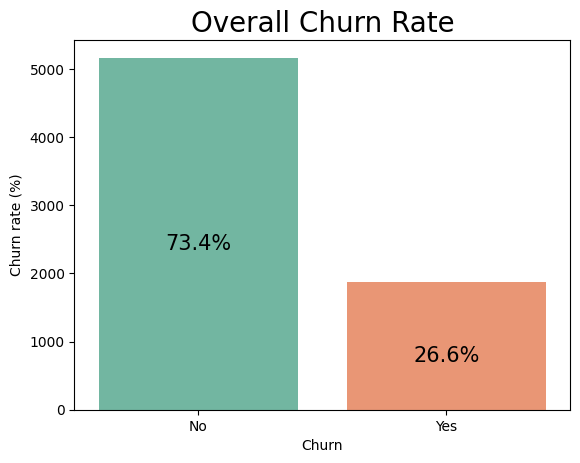

In [4]:
ax=sns.countplot(data=df, x="churn",palette="Set2")
ax.set_title("Overall Churn Rate", fontsize=20)
ax.set_ylabel("Churn rate (%)")
ax.set_xlabel("Churn")
for p in ax.patches:
    ax.annotate(f"{p.get_height()/df.shape[0]*100:.1f}%", 
                (p.get_x()+p.get_width()/2, p.get_height()/2),
                ha='center', va='top', fontsize=15)
plt.show()

Missing columns (if any): ['senior_citizen']


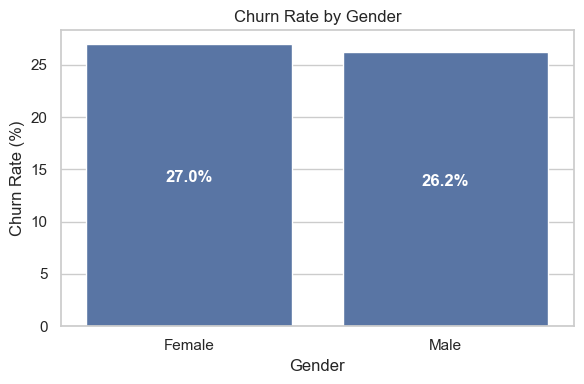

Churn % by Gender:
    gender  percent
1  Female    26.96
3    Male    26.20


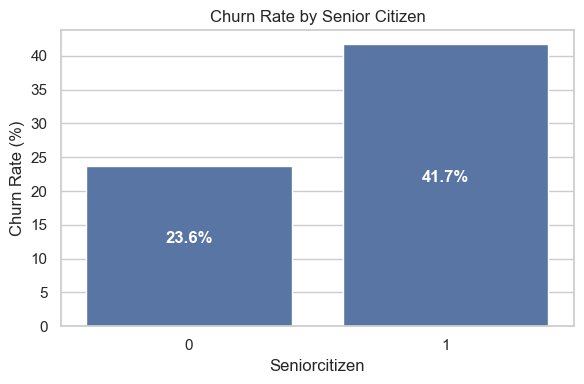

Churn % by Senior Citizen:
    seniorcitizen  percent
3              1    41.68
1              0    23.65


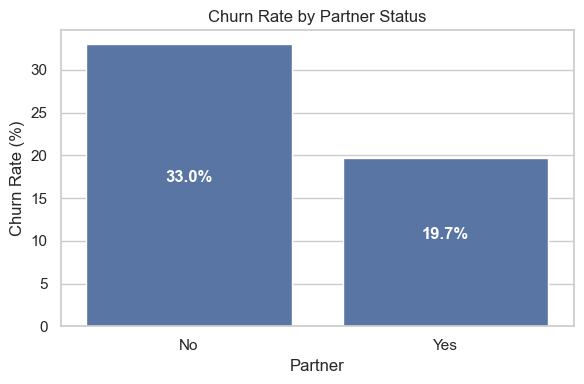

Churn % by Partner:
   partner  percent
1      No    32.98
3     Yes    19.72


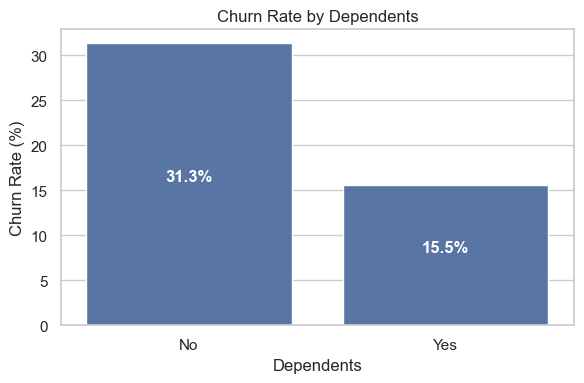

Churn % by Dependents:
   dependents  percent
1         No    31.28
3        Yes    15.53


In [5]:


# ------------- Setup -------------
sns.set(style="whitegrid")
out_dir = Path("../Screenshots")
out_dir.mkdir(parents=True, exist_ok=True)


# Ensure expected column names exist after our snake_case step
expected_cols = ["gender","senior_citizen","partner","dependents","churn"]
missing = [c for c in expected_cols if c not in df.columns]
print("Missing columns (if any):", missing)

# ------------- Helper: churn % by category -------------
def churn_rate_by(col):
    tmp = (
        df.groupby(col)["churn"]
        .value_counts(normalize=True)
        .rename("percent")
        .mul(100)
        .reset_index()
    )
    # Keep only the "Yes" rows to show churn rate within each category
    tmp = tmp[tmp["churn"] == "Yes"].drop(columns=["churn"]).sort_values("percent", ascending=False)
    tmp["percent"] = tmp["percent"].round(2)
    return tmp

def plot_percent_bar(col, title=None, filename=None):
    perc = churn_rate_by(col)
    plt.figure(figsize=(6,4))
    ax = sns.barplot(data=perc, x=col, y="percent")
    ax.set_ylabel("Churn Rate (%)")
    ax.set_xlabel(col.replace("_"," ").title())
    ax.set_title(title or f"Churn Rate by {col.replace('_',' ').title()}")
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.1f}%", 
                    (p.get_x()+p.get_width()/2, p.get_height()/2),
                    ha='center', va='bottom', fontsize=12, color="white", weight="bold")
    plt.tight_layout()
    if filename:
        plt.savefig(out_dir / filename, dpi=150)
    plt.show()
    return perc

# ------------- Compute tables + plots -------------
gender_churn      = plot_percent_bar("gender",         "Churn Rate by Gender",          "churn_by_gender.png")
print("Churn % by Gender:\n", gender_churn)

senior_churn      = plot_percent_bar("seniorcitizen", "Churn Rate by Senior Citizen",  "churn_by_senior.png")
print("Churn % by Senior Citizen:\n", senior_churn)

partner_churn     = plot_percent_bar("partner",        "Churn Rate by Partner Status",  "churn_by_partner.png")
print("Churn % by Partner:\n", partner_churn)

dependents_churn  = plot_percent_bar("dependents",     "Churn Rate by Dependents",      "churn_by_dependents.png")
print("Churn % by Dependents:\n", dependents_churn)

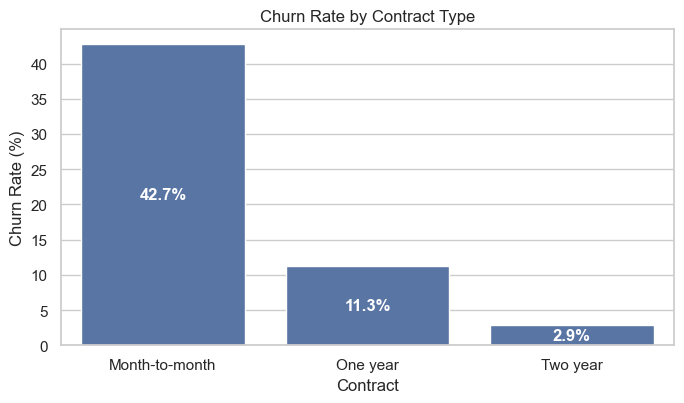


Churn % by Contract:
          contract  percent
0  Month-to-month    42.71
1        One year    11.28
2        Two year     2.85


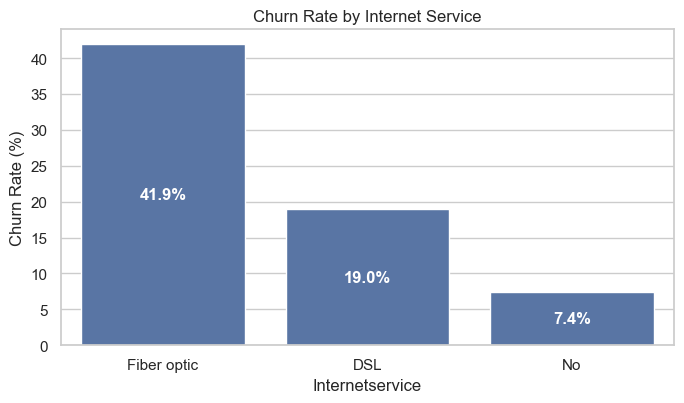


Churn % by Internet Service:
   internetservice  percent
0     Fiber optic    41.89
1             DSL    19.00
2              No     7.43


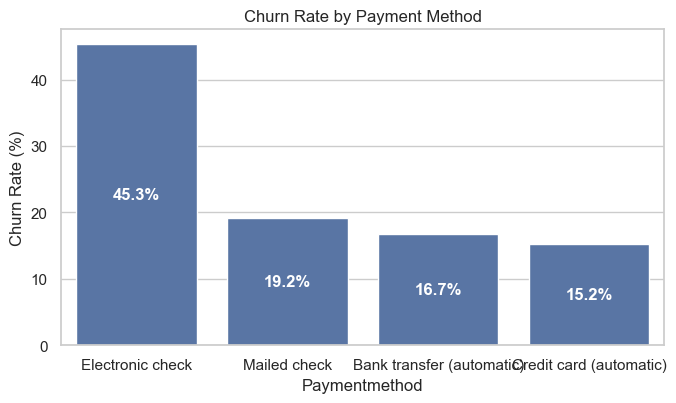


Churn % by Payment Method:
                paymentmethod  percent
0           Electronic check    45.29
1               Mailed check    19.20
2  Bank transfer (automatic)    16.73
3    Credit card (automatic)    15.25


In [6]:
# ---------- Helper: churn % by category (sorted) ----------
def churn_rate_by(df, col):
    tmp = (
        df.groupby(col)["churn"]
          .value_counts(normalize=True)       # % within each category
          .rename("percent")
          .mul(100)
          .reset_index()
    )
    tmp = tmp[tmp["churn"] == "Yes"].drop(columns=["churn"])
    tmp["percent"] = tmp["percent"].round(2)
    return tmp.sort_values("percent", ascending=False).reset_index(drop=True)

# ---------- Helper: plot bar with % labels & optional save ----------
def plot_percent_bar_table(df, col, title=None, filename=None):
    perc = churn_rate_by(df, col)
    plt.figure(figsize=(7,4.2))
    ax = sns.barplot(data=perc, x=col, y="percent", order=perc[col].tolist())
    ax.set_xlabel(col.replace("_"," ").title())
    ax.set_ylabel("Churn Rate (%)")
    ax.set_title(title or f"Churn Rate by {col.replace('_',' ').title()}")
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.1f}%",
                    (p.get_x()+p.get_width()/2, p.get_height()/2),
                    ha="center", va="center", fontsize=12, color="white", weight="bold")
    plt.tight_layout()
    if filename:
        plt.savefig(out_dir / filename, dpi=150)
    plt.show()
    return perc

# ---------- 1) Contract type ----------
contract_churn = plot_percent_bar_table(
    df, "contract",
    title="Churn Rate by Contract Type",
    filename="churn_by_contract.png"
)
print("\nChurn % by Contract:\n", contract_churn)

# ---------- 2) Internet service ----------
internet_churn = plot_percent_bar_table(
    df, "internetservice",
    title="Churn Rate by Internet Service",
    filename="churn_by_internet_service.png"
)
print("\nChurn % by Internet Service:\n", internet_churn)

# ---------- 3) Payment method ----------
payment_churn = plot_percent_bar_table(
    df, "paymentmethod",
    title="Churn Rate by Payment Method",
    filename="churn_by_payment_method.png"
)
print("\nChurn % by Payment Method:\n", payment_churn)

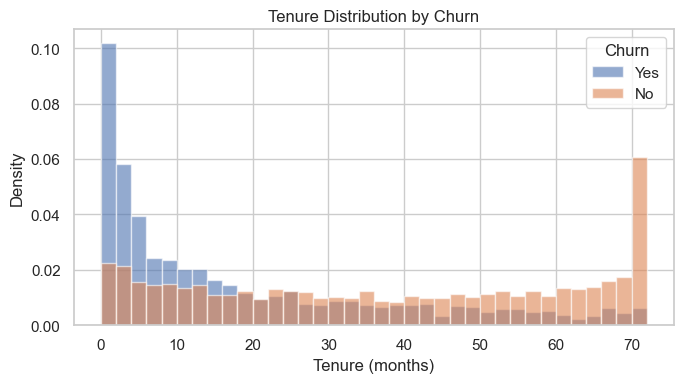


Churn % by Tenure Bin:
   tenure_bin  percent
0        0–6    54.71
1       6–12    36.53
2      12–24    29.51
3      24–36    22.03
4      36–48    19.52
5      48–60    15.00
6      60–72     8.30


C:\Users\user\AppData\Local\Temp\ipykernel_10316\3078710307.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("tenure_bin")["churn"]


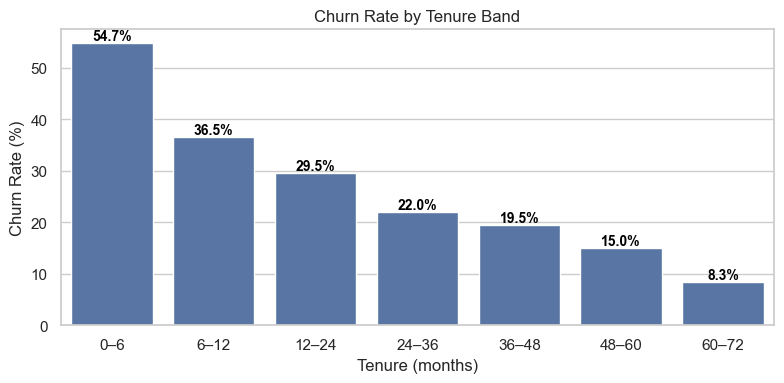

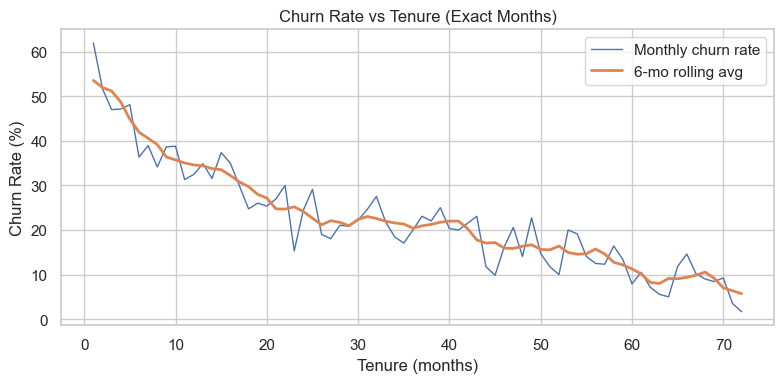

In [7]:


# ---- 1) Distribution: tenure by churn (two histograms) ----
plt.figure(figsize=(7,4))
bins = np.arange(0, df["tenure"].max()+2, 2)  # 2-month bins for detail
for label in ["Yes","No"]:
    subset = df[df["churn"] == label]["tenure"]
    plt.hist(subset, bins=bins, alpha=0.6, label=label, density=True)
plt.xlabel("Tenure (months)"); plt.ylabel("Density")
plt.title("Tenure Distribution by Churn")
plt.legend(title="Churn")
plt.tight_layout(); plt.savefig(out_dir/"tenure_dist_by_churn.png", dpi=150); plt.show()

# ---- 2) Binned churn rate (clean table + bar) ----
# Define business-friendly bins
bin_edges = [0, 6, 12, 24, 36, 48, 60, 72]  # 0–6, 6–12, ..., 60–72+
labels = ["0–6","6–12","12–24","24–36","36–48","48–60","60–72"]
df["tenure_bin"] = pd.cut(df["tenure"].clip(upper=72), bins=bin_edges, labels=labels, right=False, include_lowest=True)

churn_by_bin = (
    df.groupby("tenure_bin")["churn"]
      .value_counts(normalize=True)
      .rename("percent").mul(100).reset_index()
)
churn_by_bin = churn_by_bin[churn_by_bin["churn"]=="Yes"][["tenure_bin","percent"]].reset_index(drop=True)
churn_by_bin["percent"] = churn_by_bin["percent"].round(2)
print("\nChurn % by Tenure Bin:\n", churn_by_bin)

plt.figure(figsize=(8,4))
ax = sns.barplot(data=churn_by_bin, x="tenure_bin", y="percent")
ax.set_xlabel("Tenure (months)")
ax.set_ylabel("Churn Rate (%)")
ax.set_title("Churn Rate by Tenure Band")
for p in ax.patches:
    ax.annotate(f"{p.get_height():.1f}%", (p.get_x()+p.get_width()/2, p.get_height()),
                ha="center", va="bottom", fontsize=10, color="black", weight="bold")
plt.tight_layout(); plt.savefig(out_dir/"churn_by_tenure_band.png", dpi=150); plt.show()

# ---- 3) Smooth trend of churn vs tenure (rolling mean) ----
# Compute churn rate per exact tenure month, then smooth
monthly = (df.groupby("tenure")["churn"]
             .apply(lambda s: (s=="Yes").mean()*100)
             .reset_index(name="churn_rate"))
monthly["churn_rate_smooth"] = monthly["churn_rate"].rolling(window=6, min_periods=1, center=True).mean()

plt.figure(figsize=(8,4))
plt.plot(monthly["tenure"], monthly["churn_rate"], linewidth=1, label="Monthly churn rate")
plt.plot(monthly["tenure"], monthly["churn_rate_smooth"], linewidth=2, label="6-mo rolling avg")
plt.xlabel("Tenure (months)"); plt.ylabel("Churn Rate (%)")
plt.title("Churn Rate vs Tenure (Exact Months)")
plt.legend()
plt.tight_layout(); plt.savefig(out_dir/"churn_vs_tenure_trend.png", dpi=150); plt.show()

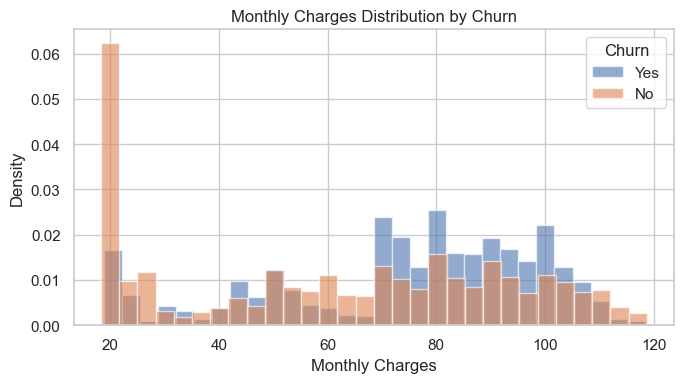

In [8]:
# ---------- 1) MonthlyCharges: distribution by churn ----------
plt.figure(figsize=(7,4))
for label in ["Yes","No"]:
    subset = df[df["churn"]==label]["monthlycharges"]
    plt.hist(subset, bins=30, alpha=0.6, label=label, density=True)
plt.xlabel("Monthly Charges"); plt.ylabel("Density")
plt.title("Monthly Charges Distribution by Churn")
plt.legend(title="Churn")
plt.tight_layout(); plt.savefig(out_dir/"monthly_charges_dist_by_churn.png", dpi=150); plt.show()



Churn % by MonthlyCharges bin (quintiles):
             mc_bin  percent
0  (18.249, 25.05]     9.18
1   (25.05, 58.92]    24.98
2   (58.92, 79.15]    29.96
3    (79.15, 94.3]    35.97
4   (94.3, 118.75]    32.93


C:\Users\user\AppData\Local\Temp\ipykernel_10316\783784707.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("mc_bin")["churn"].value_counts(normalize=True)


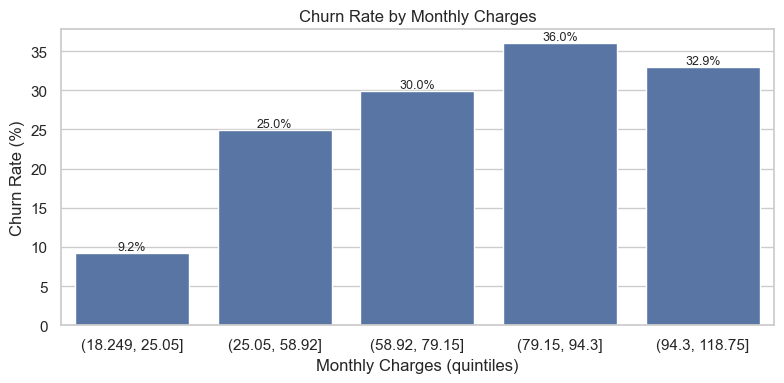

In [12]:
# ---------- 2) MonthlyCharges: binned churn rate (quantiles) ----------
df["mc_bin"] = pd.qcut(df["monthlycharges"], q=5, duplicates="drop")  # quintiles
mc_churn = (
    df.groupby("mc_bin")["churn"].value_counts(normalize=True)
      .rename("percent").mul(100).reset_index()
)
mc_churn = mc_churn[mc_churn["churn"]=="Yes"][["mc_bin","percent"]].reset_index(drop=True)
mc_churn["percent"] = mc_churn["percent"].round(2)
print("\nChurn % by MonthlyCharges bin (quintiles):\n", mc_churn)

plt.figure(figsize=(8,4))
ax = sns.barplot(data=mc_churn, x="mc_bin", y="percent")
ax.set_xlabel("Monthly Charges (quintiles)"); ax.set_ylabel("Churn Rate (%)")
ax.set_title("Churn Rate by Monthly Charges")
for p in ax.patches:
    ax.annotate(f"{p.get_height():.1f}%", (p.get_x()+p.get_width()/2, p.get_height()),
                ha="center", va="bottom", fontsize=9)
plt.tight_layout(); plt.savefig(out_dir/"churn_by_monthly_charges_bins.png", dpi=150); plt.show()

Churn % by TotalCharges bin (quintiles):
                tc_bin  percent
0    (18.799, 267.07]    45.98
1    (267.07, 944.17]    28.95
2   (944.17, 2048.95]    20.77
3  (2048.95, 4475.41]    23.04
4   (4475.41, 8684.8]    14.14


C:\Users\user\AppData\Local\Temp\ipykernel_10316\1456068018.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tc_churn=df.groupby("tc_bin")["churn"].value_counts(normalize=True).rename("percent").mul(100).reset_index()


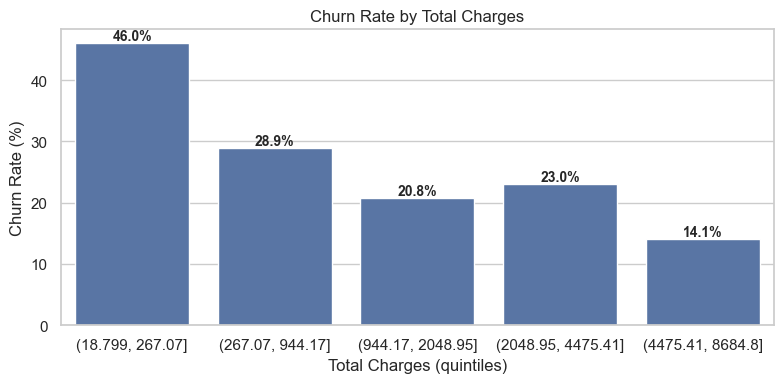

In [15]:
df["tc_bin"]=pd.qcut(df["totalcharges"], q=5, duplicates="drop")
tc_churn=df.groupby("tc_bin")["churn"].value_counts(normalize=True).rename("percent").mul(100).reset_index()
tc_churn=tc_churn[tc_churn["churn"]=="Yes"][["tc_bin","percent"]].reset_index(drop=True)
tc_churn["percent"]=tc_churn["percent"].round(2)

print("Churn % by TotalCharges bin (quintiles):\n", tc_churn)

plt.figure(figsize=(8,4))
ax=sns.barplot(data=tc_churn, x="tc_bin", y="percent")
ax.set_xlabel("Total Charges (quintiles)"); ax.set_ylabel("Churn Rate (%)")
ax.set_title("Churn Rate by Total Charges")
for p in ax.patches:
    ax.annotate(f"{p.get_height():.1f}%", (p.get_x()+p.get_width()/2, p.get_height()), ha="center", va="bottom", fontsize=10, weight="bold")

plt.tight_layout()
plt.savefig(out_dir/"churn_by_total_charges_bins.png", dpi=150)

plt.show()

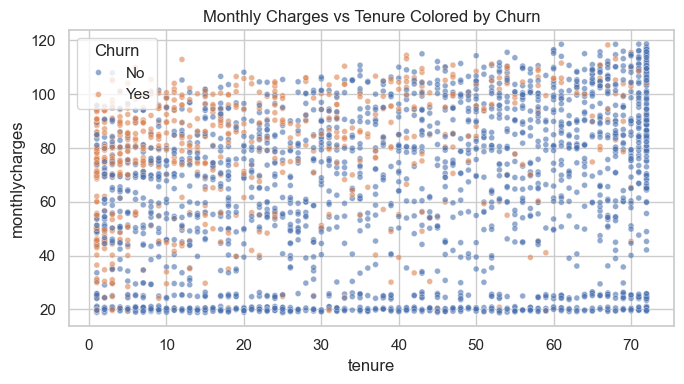

In [22]:
plt.figure(figsize=(7,4))
sns.scatterplot(data=df.sample(min(3000, len(df)), random_state=42), 
                x="tenure", y="monthlycharges", hue="churn",alpha=0.6, s=18)
plt.title("Monthly Charges vs Tenure Colored by Churn")
plt.legend(title="Churn")
plt.tight_layout()
plt.savefig(out_dir/"scatter_tenure_vs_monthly_charges.png", dpi=150)

plt.show()


In [30]:
db_path=Path("../data/churn.duckdb")
csv_path=Path("../data/telco_dataset_cleaned.csv")
sql_out=Path("../sql"); sql_out.mkdir(parents=True, exist_ok=True)

In [31]:
con=duckdb.connect(str(db_path))

con.execute("""
            CREATE OR REPLACE TABLE telco AS
            SELECT * FROM read_csv_auto($csv, HEADER=True);
            """, {"csv": str(csv_path)})

In [33]:
con.execute("SELECT COUNT(*) AS rows, COUNT (DISTINCT customerid) AS unique_ids FROM telco").df()

,rows,unique_ids
0,7032,7032


In [46]:
overall = con.execute("""
SELECT
  churn,
  COUNT(*) AS n,
  ROUND(100.0 * COUNT(*) / SUM(COUNT(*)) OVER (), 2) AS pct
FROM telco
GROUP BY churn
ORDER BY churn DESC;
""").df()

overall.to_csv(sql_out / "overall_churn.csv", index=False)
overall

,churn,n,pct
0,True,1869,26.58
1,False,5163,73.42


In [47]:
by_contract = con.execute("""
                          SELECT
                            contract,
                            COUNT(*) AS customers,
                            SUM (CASE WHEN churn = 'Yes' THEN 1 ELSE 0 END) AS churn_yes,
                            ROUND(100.0 * AVG(CASE WHEN churn = 'Yes' THEN 1.0 ELSE 0.0 END),2) AS churn_pct
                          FROM telco
                          GROUP BY contract
                          ORDER BY churn_pct DESC;
                          """).df()
by_contract.to_csv(sql_out/"churn_by_contract.csv", index=False)
by_contract

,contract,customers,churn_yes,churn_pct
0,Month-to-month,3875,1655.0,42.71
1,One year,1472,166.0,11.28
2,Two year,1685,48.0,2.85


In [48]:
df.columns

Index(['customerid', 'gender', 'seniorcitizen', 'partner', 'dependents',
       'tenure', 'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod', 'monthlycharges', 'totalcharges', 'churn'],
      dtype='object')

In [71]:
by_inet = con.execute("""
                      SELECT
                      internetservice,
                      COUNT(*) AS customers,
                      ROUND(100.0 * AVG(CASE WHEN churn = 'Yes' THEN 1.0 ELSE 0.0 END),2) AS churn_pct,
                      FROM telco
                      GROUP BY internetservice
                      ORDER BY churn_pct DESC;
                      """).df()

by_inet.to_csv(sql_out/"churn_by_internet_service.csv", index=False)
by_inet

,internetservice,customers,churn_pct
0,Fiber optic,3096,41.89
1,DSL,2416,19.00
2,No,1520,7.43


In [72]:
by_tenure =  con.execute("""
              WITH labeled AS (
                SELECT *,
                    CASE 
                        WHEN tenure < 6 THEN '0-6'
                        WHEN tenure < 12 THEN '6-12'
                        WHEN tenure < 24 THEN '12-24'
                        WHEN tenure < 36 THEN '24-36'
                        WHEN tenure < 48 THEN '36-48'
                        WHEN tenure < 60 THEN '48-60'
                        ELSE '60-72' 
                    END AS tenure_band
                FROM telco
              )
              SELECT
                tenure_band,
                COUNT(*) AS customers,
                ROUND(100.0 * AVG(CASE WHEN churn = 'Yes' THEN 1.0 ELSE 0.0 END), 2) AS churn_pct
            FROM labeled
            GROUP BY tenure_band
            ORDER BY 
                CASE tenure_band
                    WHEN '0-6' THEN 1 
                    WHEN '6-12' THEN 2 
                    WHEN '12-24' THEN 3 
                    WHEN '24-36' THEN 4 
                    WHEN '36-48' THEN 5 
                    WHEN '48-60' THEN 6 
                    ELSE 7 
                END;
            """).df()
by_tenure.to_csv(sql_out/"churn_by_tenure.csv", index=False)
by_tenure

,tenure_band,customers,churn_pct
0,0-6,1360,54.71
1,6-12,698,36.53
2,12-24,1047,29.51
3,24-36,876,22.03
4,36-48,748,19.52
5,48-60,820,15.00
6,60-72,1483,6.68


In [75]:
by_pay = con.execute("""
                     SELECT
                       paymentmethod,
                       COUNT(*) AS customers,
                       ROUND(100.0 * AVG(CASE WHEN churn = 'Yes' THEN 1.0 ELSE 0.0 END),2) AS churn_pct
                     FROM telco
                     GROUP BY paymentmethod
                     ORDER BY churn_pct DESC;
                     """).df()
by_pay.to_csv(sql_out/"churn_by_payment_method.csv", index=False)
by_pay

,paymentmethod,customers,churn_pct
0,Electronic check,2365,45.29
1,Mailed check,1604,19.20
2,Bank transfer (automatic),1542,16.73
3,Credit card (automatic),1521,15.25


In [80]:
by_mc_quint = con.execute("""
                          WITH bounds AS(
                          SELECT
                            quantile_cont(monthlycharges, 0.2) AS q1,
                            quantile_cont(monthlycharges, 0.4) AS q2,
                            quantile_cont(monthlycharges, 0.6) AS q3,
                            quantile_cont(monthlycharges, 0.8) AS q4
                          FROM telco
                        ),
                          labeled AS (
                          SELECT t.*,
                          CASE 
                            WHEN t.monthlycharges<=b.q1 THEN 'Q1(lowest)'
                            WHEN t.monthlycharges<=b.q2 THEN 'Q2'
                            WHEN t.monthlycharges<=b.q3 THEN 'Q3'
                            WHEN t.monthlycharges<=b.q4 THEN 'Q4'
                            ELSE 'Q5(highest)' 
                          END AS mc_quint
                          FROM telco t, bounds b
                        )
                          SELECT  
                            mc_quint,
                            COUNT(*) AS customers,
                            ROUND(100.0 * AVG(CASE WHEN churn = 'Yes' THEN 1.0 ELSE 0.0 END),2) AS churn_pct
                          FROM labeled
                          GROUP BY mc_quint
                          ORDER BY
                            CASE mc_quint
                                WHEN 'Q1(lowest)' THEN 1
                                WHEN 'Q2' THEN 2
                                WHEN 'Q3' THEN 3
                                WHEN 'Q4' THEN 4
                                ELSE 5
                            END;
                          """).df()
by_mc_quint.to_csv(sql_out/"churn_by_monthly_charges_quintiles.csv", index=False)
by_mc_quint
                          

,mc_quint,customers,churn_pct
0,Q1(lowest),1416,9.18
1,Q2,1397,24.98
2,Q3,1415,29.96
3,Q4,1404,35.97
4,Q5(highest),1400,32.93
